# 🔍 Model OCR

Este cuaderno tiene como objetivo principal explorar, implementar y evaluar un sistema de **Reconocimiento Óptico de Caracteres (OCR)** aplicado a imágenes de componentes de hardware de PC. A partir de un dataset previamente construido mediante scraping y limpieza de datos, se analizará la capacidad del OCR para extraer información textual relevante como marcas, modelos, códigos técnicos y otros identificadores impresos en los propios componentes.

Este cuaderno servirá como base experimental para validar la viabilidad del OCR en este dominio específico, así como para estudiar sus limitaciones en componentes que no contienen texto visible, sentando las bases para los futuros sistemas a implementar.

### 👨‍💻 Autores del proyecto

* [Alejandro Barrionuevo Rosado](https://github.com/Alejandro-BR)
* [Alvaro López Guerrero](https://github.com/Alvalogue72)
* [Andrei Munteanu Popa](https://github.com/andu8705)

Máster de FP en Inteligencia Artifical y Big Data - CPIFP Alan Turing - `Curso 2025/2026`

## Importaciones de paquetes

In [67]:
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import easyocr
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud


## Obtención de datos

**Fuente:** [components_03.csv](https://raw.githubusercontent.com/Latency-Zero-tfm/HardVisionAI/refs/heads/main/data/processed/components_03.csv)

Utilizaremos nuestro dataset resultante del web scraping de distintas páginas, ya procesado y listo para usar en nuestro modelo.

### Descripción de los datos

El dataset cuenta con  y **2 columnas**, de las cuales `label` es de tipo `int64` e `image` es de tipo `object`, ya que contiene la imagen vectorizada.

| Columna | Tipo   | Descripción                                        |
| ------- | ------ | -------------------------------------------------- |
| image   | object | Imagen vectorizada del componente de computadora   |
| label   | int64  | Etiqueta numérica que indica el tipo de componente |

El **target** que se busca predecir es el **label**, es decir, el tipo de componente.

| Número | Componente     |
| ------ | -------------- |
| 0      | motherboard    |
| 1      | gpu            |
| 2      | cpu            |
| 3      | hard_drive     |
| 4      | ram            |
| 5      | pc_case        |
| 6      | power_supply   |
| 7      | liquid_cooling |
| 8      | case_fan       |
| 9      | cpu_fan        |
| 10     | sound_card     |


In [2]:
df = pd.read_csv("../data/processed/components_03.csv")

In [3]:
df.info()
df

<class 'pandas.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   local_image_path  9971 non-null   str  
 1   label             9971 non-null   int64
dtypes: int64(1), str(1)
memory usage: 155.9 KB


local_image_path  label
0       ../data/images/motherboard_0.jpg      0
1       ../data/images/motherboard_1.jpg      0
2       ../data/images/motherboard_2.jpg      0
3       ../data/images/motherboard_3.jpg      0
4       ../data/images/motherboard_4.jpg      0
...                                  ...    ...
9966  ../data/images/hard_drive_9977.jpg      3
9967  ../data/images/hard_drive_9978.jpg      3
9968  ../data/images/hard_drive_9979.jpg      3
9969  ../data/images/hard_drive_9980.jpg      3
9970  ../data/images/hard_drive_9981.jpg      3

[9971 rows x 2 columns]

In [4]:
label_map = {
    0: 'motherboard',
    1: 'gpu',
    2: 'cpu',
    3: 'hard_drive',
    4: 'ram',
    5: 'pc_case',
    6: 'power_supply',
    7: 'liquid_cooling',
    8: 'case_fan',
    9: 'cpu_fan',
    10: 'sound_card'
}

## Procesamiento de imágenes

En esta sección se aplica el OCR a todas las imágenes del dataset para extraer el texto visible en los componentes de PC. 
Se procesan las imágenes una a una y se almacenan los resultados en un nuevo CSV con el texto detectado.

In [5]:
reader = easyocr.Reader(['en'], gpu=True)

ocr_texts = []
ocr_confidences = []
ocr_blocks = []

for img_path in tqdm(df["local_image_path"]):
    try:
        img = cv2.imread(img_path)
        if img is None:
            ocr_texts.append("")
            ocr_confidences.append(0)
            ocr_blocks.append(0)
            continue

        results = reader.readtext(img)

        texts = [text for _, text, _ in results]
        confidences = [conf for _, _, conf in results]

        ocr_texts.append(" | ".join(texts))
        ocr_confidences.append(sum(confidences) / len(confidences) if confidences else 0)
        ocr_blocks.append(len(texts))

    except Exception as e:
        ocr_texts.append("")
        ocr_confidences.append(0)
        ocr_blocks.append(0)

df["ocr_text"] = ocr_texts
df["ocr_avg_confidence"] = ocr_confidences
df["ocr_num_blocks"] = ocr_blocks

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
  0%|          | 0/9971 [00:00<?, ?it/s]c:\Users\abarr\Documents\HardVisionAI\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
100%|██████████| 9971/9971 [1:53:08<00:00,  1.47it/s]  


## Guardar el dataframe obtenido

Se almacena el dataframe resultante en un nuevo dataset, facilitando su análisis posterior y su uso en las siguientes etapas del proyecto.


In [5]:
df.to_csv("../data/processed/components_04.csv", index=False)

In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   local_image_path    9971 non-null   str    
 1   label               9971 non-null   int64  
 2   ocr_text            6434 non-null   str    
 3   ocr_avg_confidence  9971 non-null   float64
 4   ocr_num_blocks      9971 non-null   int64  
dtypes: float64(1), int64(2), str(2)
memory usage: 389.6 KB


In [10]:
df

local_image_path  label  \
0       ../data/images/motherboard_0.jpg      0   
1       ../data/images/motherboard_1.jpg      0   
2       ../data/images/motherboard_2.jpg      0   
3       ../data/images/motherboard_3.jpg      0   
4       ../data/images/motherboard_4.jpg      0   
...                                  ...    ...   
9966  ../data/images/hard_drive_9977.jpg      3   
9967  ../data/images/hard_drive_9978.jpg      3   
9968  ../data/images/hard_drive_9979.jpg      3   
9969  ../data/images/hard_drive_9980.jpg      3   
9970  ../data/images/hard_drive_9981.jpg      3   

                                               ocr_text  ocr_avg_confidence  \
0             BGsdM | PRD-VDH | Hadi | B5SC | msi | m5i            0.242091   
1                               8850 Grming plus | 8501            0.455908   
2     5 | 1 | 2 | 1 | BzG0M | ds3h @DRk | GIGABYTE |...            0.299432   
3     64MB | R24@7 FOR | BlOS | 7ii: (F | 0aG | bosi...            0.438131   
4                          PRIME | BSSOM-A | II | 3 | 4            0.456415   
...                                                 ...                 ...   
9966       AdBUD" 9n7a Ie | WD | BLacK | Wcatcin Diclal            0.141853   
9967            ner-aln | s0oG8 | NvZii | 68K@ ZEcnvn :            0.094094   
9968                           crucial | T500 | KneMis'            0.635752   
9969  Jnicron | P31O | crucial | PCIo" Gtna NVMe" M2...            0.627579   
9970  GSEAGATE | Desktop HDD | 9 | (€ 2 | seagale co...            0.504726   

      ocr_num_blocks  
0                  6  
1                  2  
2                  9  
3                  9  
4                  5  
...              ...  
9966               4  
9967               4  
9968               3  
9969               4  
9970               7  

[9971 rows x 5 columns]

## Leer el nuevo dataset

Se carga el dataset generado para verificar su contenido y continuar con el análisis y procesamiento de los datos.


In [8]:
df = pd.read_csv("../data/processed/components_04.csv")

## Exploración y verificación del OCR

En esta sección se analiza el dataset generado para evaluar el rendimiento del OCR, identificando qué tipos de texto detecta correctamente y en qué casos presenta errores o limitaciones.


In [13]:
df.info()
df

<class 'pandas.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   local_image_path    9971 non-null   str    
 1   label               9971 non-null   int64  
 2   ocr_text            6434 non-null   str    
 3   ocr_avg_confidence  9971 non-null   float64
 4   ocr_num_blocks      9971 non-null   int64  
dtypes: float64(1), int64(2), str(2)
memory usage: 389.6 KB


local_image_path  label  \
0       ../data/images/motherboard_0.jpg      0   
1       ../data/images/motherboard_1.jpg      0   
2       ../data/images/motherboard_2.jpg      0   
3       ../data/images/motherboard_3.jpg      0   
4       ../data/images/motherboard_4.jpg      0   
...                                  ...    ...   
9966  ../data/images/hard_drive_9977.jpg      3   
9967  ../data/images/hard_drive_9978.jpg      3   
9968  ../data/images/hard_drive_9979.jpg      3   
9969  ../data/images/hard_drive_9980.jpg      3   
9970  ../data/images/hard_drive_9981.jpg      3   

                                               ocr_text  ocr_avg_confidence  \
0             BGsdM | PRD-VDH | Hadi | B5SC | msi | m5i            0.242091   
1                               8850 Grming plus | 8501            0.455908   
2     5 | 1 | 2 | 1 | BzG0M | ds3h @DRk | GIGABYTE |...            0.299432   
3     64MB | R24@7 FOR | BlOS | 7ii: (F | 0aG | bosi...            0.438131   
4                          PRIME | BSSOM-A | II | 3 | 4            0.456415   
...                                                 ...                 ...   
9966       AdBUD" 9n7a Ie | WD | BLacK | Wcatcin Diclal            0.141853   
9967            ner-aln | s0oG8 | NvZii | 68K@ ZEcnvn :            0.094094   
9968                           crucial | T500 | KneMis'            0.635752   
9969  Jnicron | P31O | crucial | PCIo" Gtna NVMe" M2...            0.627579   
9970  GSEAGATE | Desktop HDD | 9 | (€ 2 | seagale co...            0.504726   

      ocr_num_blocks  
0                  6  
1                  2  
2                  9  
3                  9  
4                  5  
...              ...  
9966               4  
9967               4  
9968               3  
9969               4  
9970               7  

[9971 rows x 5 columns]

### Valores nulos
En este subapartado vamos a analizar cuántos valores nulos existen y en qué variables se encuentran.

In [14]:
df.isnull().sum()

local_image_path         0
label                    0
ocr_text              3537
ocr_avg_confidence       0
ocr_num_blocks           0
dtype: int64

Los valores nulos aparecen en los resultados del OCR, por lo que a continuación se analizará a qué etiquetas (`label`) pertenecen.


In [ ]:
nulls_por_label = df.groupby("label")["ocr_text"].apply(lambda x: x.isnull().sum())

nulls_por_label_named = nulls_por_label.rename(index=label_map)
nulls_por_label_named


label
motherboard        106
gpu                135
cpu                 15
hard_drive         278
ram                205
pc_case           1332
power_supply       218
liquid_cooling     574
case_fan           398
cpu_fan            266
sound_card          10
Name: ocr_text, dtype: int64

Podemos observar que el mayor número de valores nulos se presenta en las cajas de PC, lo cual tiene todo el sentido, ya que este tipo de componente normalmente no muestra texto ni etiquetas visibles en la propia imagen. Además, información como el tamaño o modelo suele aparecer en el embalaje, no en el producto en sí, por lo que el OCR no dispone de datos útil


In [22]:
total_per_label = df.groupby("label").size()

summary_per_label = pd.DataFrame({
    "total_images": total_per_label,
    "ocr_nulls": nulls_por_label
}).rename(index=label_map)

summary_per_label


total_images  ocr_nulls
label                                  
motherboard              859        106
gpu                      632        135
cpu                      490         15
hard_drive              1898        278
ram                     1313        205
pc_case                 1821       1332
power_supply            1003        218
liquid_cooling           879        574
case_fan                 639        398
cpu_fan                  385        266
sound_card                52         10

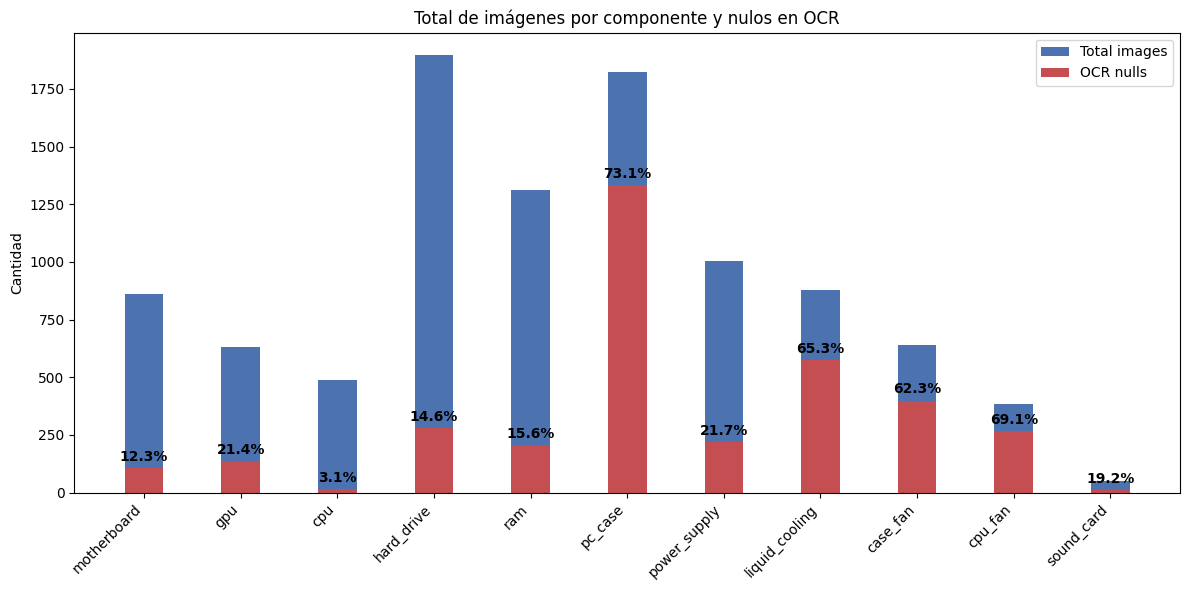

In [28]:
labels = summary_per_label.index
total_images = summary_per_label['total_images'].values 
ocr_nulls = summary_per_label['ocr_nulls'].values

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x, total_images, width, label='Total images', color='#4C72B0')

ax.bar(x, ocr_nulls, width, label='OCR nulls', color='#C44E52')

for i in range(len(x)):
    if total_images[i] > 0:
        percent = ocr_nulls[i] / total_images[i] * 100
        ax.text(x[i], ocr_nulls[i] + max(total_images)*0.01, f'{percent:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

ax.set_ylabel('Cantidad')
ax.set_title('Total de imágenes por componente y nulos en OCR')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


Podemos observar que en algunos productos, como las cajas de PC y ciertos sistemas de ventilación, no se dispone de texto en gran medida. Esto es totalmente esperado: por ejemplo, un ventilador normalmente no presenta datos visibles en la propia pieza, y si aparece texto, suele ser únicament


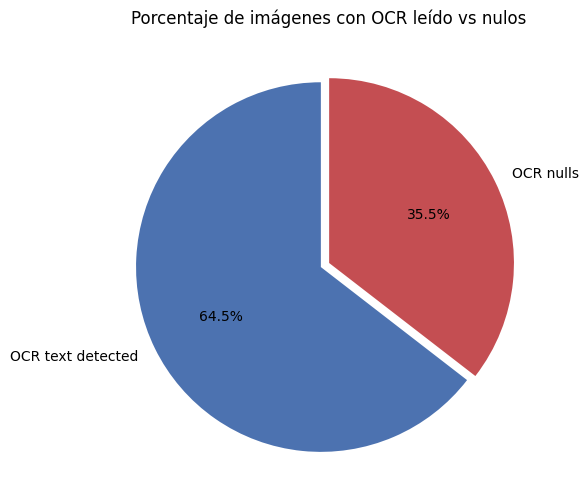

In [29]:
total_images_count = summary_per_label['total_images'].sum()
total_nulls_count = summary_per_label['ocr_nulls'].sum()
total_read_count = total_images_count - total_nulls_count

sizes = [total_read_count, total_nulls_count]
labels = ['OCR text detected', 'OCR nulls']
colors = ['#4C72B0', '#C44E52']

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0))
ax.set_title('Porcentaje de imágenes con OCR leído vs nulos')
plt.show()


En general, en términos de imágenes, el OCR ha podido extraer información de manera consistente, mostrando resultados realistas y acordes con lo que se esperaba para cada tipo de componente.


### Pruebas por tipo de componente

Se realizarán pruebas por cada tipo de componente, seleccionando aleatoriamente 10 imágenes de cada categoría para evaluar en cuáles el OCR funciona correctamente y en cuáles presenta limitaciones.


In [44]:
def show_component_images_random(df, label_map, label_num, n_show=5):
    """
    Muestra imágenes aleatorias de un componente con el texto OCR extraído.

    Parámetros:
    - df: DataFrame con las columnas 'local_image_path', 'label', 'ocr_text'
    - label_map: diccionario {label_num: label_name}
    - label_num: número del label a mostrar
    - n_show: número de imágenes a mostrar
    """
    label_name = label_map[label_num]
    
    df_label = df[df['label'] == label_num].reset_index(drop=True)
    
    df_sample = df_label.sample(n=min(n_show, len(df_label)), random_state=42)
    
    print(f"\n--- {label_name.upper()} ---")
    
    for idx, row in df_sample.iterrows():
        img_path = row['local_image_path']
        ocr_text = row['ocr_text'] if pd.notnull(row['ocr_text']) else 'Ningún texto detectado'
        
        img = Image.open(img_path)
        
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"OCR: {ocr_text}", fontsize=10)
        plt.show()


#### MOTHERBOARD

Podemos observar que el OCR detecta correctamente texto en las placas base, principalmente porque las imágenes obtenidas mediante web scraping incluyen la **caja del producto**. Sin la caja visible, sería prácticamente imposible extraer datos directamente de la placa.



--- MOTHERBOARD ---


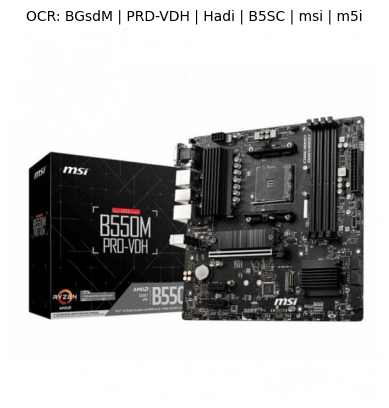

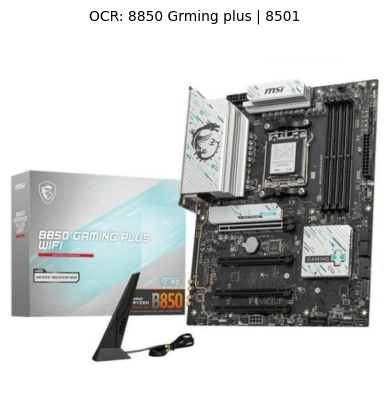

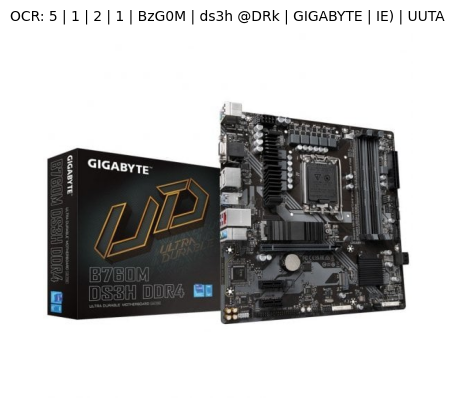

In [47]:
show_component_images(df, label_map, label_num=0, start_idx=0, n_show=3)


#### GPU

En el caso de las tarjetas gráficas, se observa un comportamiento similar. Sin embargo, si las imágenes tuvieran mayor resolución o un mejor angulo, el OCR podría haber extraído más información, ya que las tarjetas gráficas suelen mostrar **etiquetas visibles** con marca y modelo.



--- GPU ---


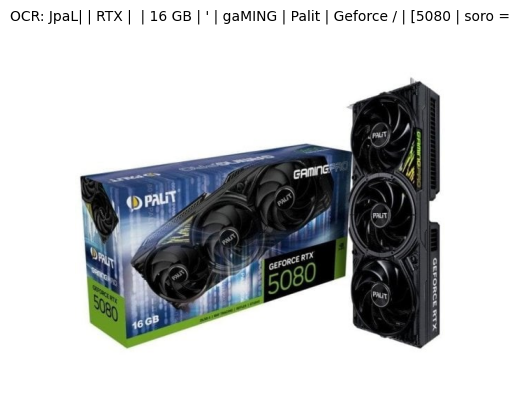

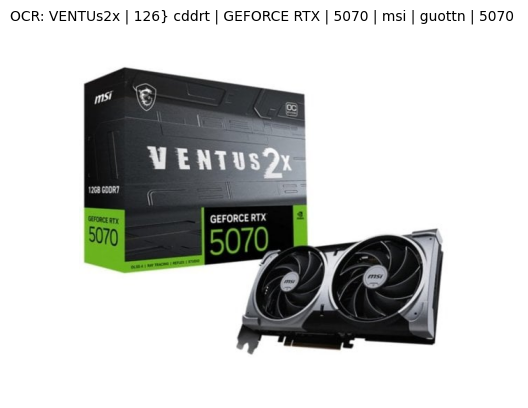

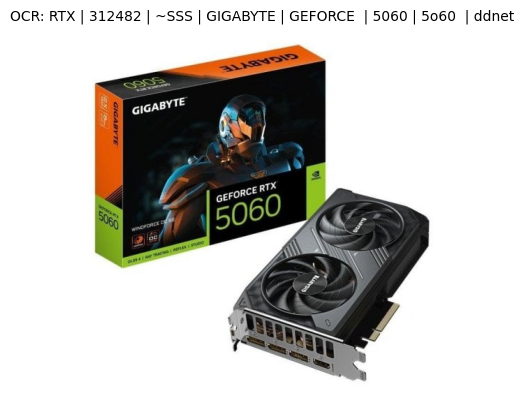

In [48]:
show_component_images(df, label_map, label_num=1, start_idx=0, n_show=3)


#### CPU

En este caso, el comportamiento es similar. Para la demostración, se seleccionará una imagen representativa y de buena calidad, basándonos en pruebas anteriores. Podemos observar que, al pasar una foto nítida de un procesador, el OCR logra extraer una cantidad considerable de información útil, como marca, modelo y otras especificaciones.

Por lo tanto, cuando la imagen es de buena calidad, el OCR funciona muy bien y puede ser de gran ayuda para que un agente identifique información del componente y determine su compatibilidad con otros elementos del sistema.


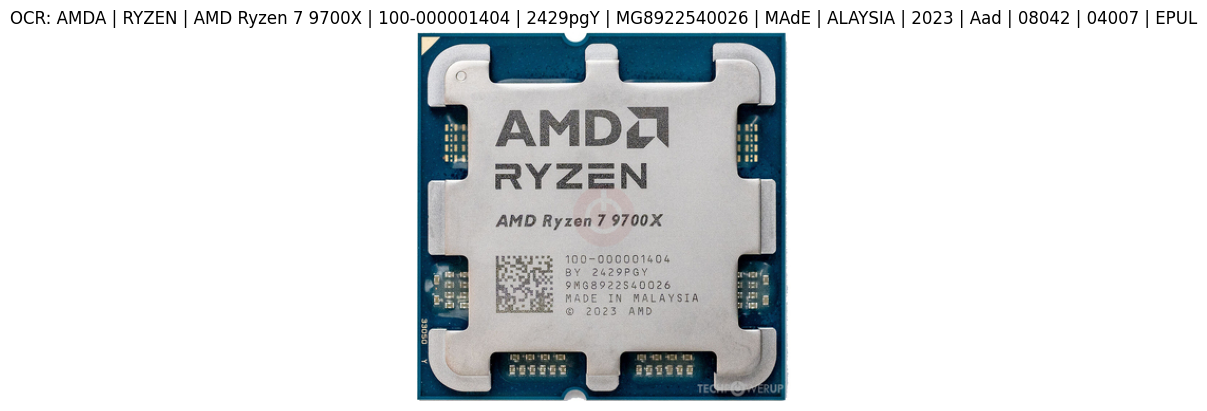

In [55]:
idx = 9121 

img_path = df.iloc[idx]["local_image_path"]
ocr_text = df.iloc[idx]["ocr_text"]

img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.title(f"OCR: {ocr_text if pd.notnull(ocr_text) else 'Ningún texto detectado'}", fontsize=12)
plt.show()


--- CPU ---


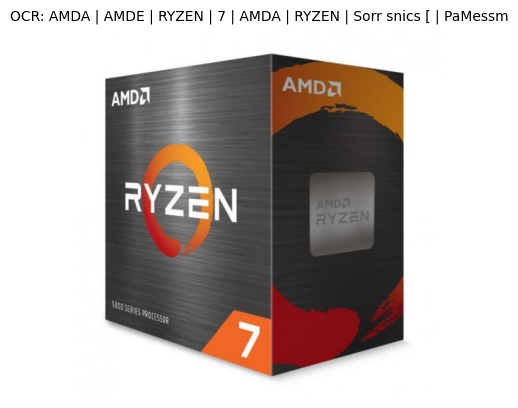

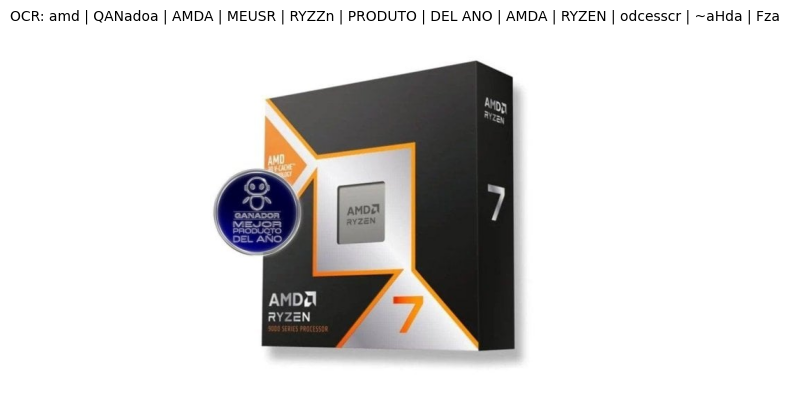

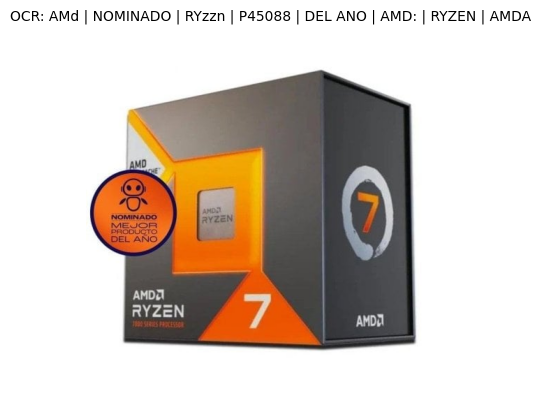

In [50]:
show_component_images(df, label_map, label_num=2, start_idx=0, n_show=3)


#### HARD_DRIVE

Al igual que con los procesadores, se observa que las imágenes de buena calidad resultan muy útiles. En muchos casos, el OCR permite identificar el tipo de disco y su capacidad, extrayendo información relevante directamente de la imagen.



--- HARD_DRIVE ---


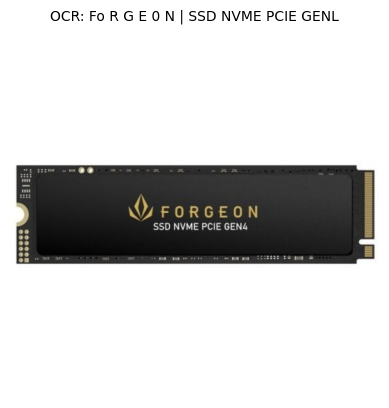

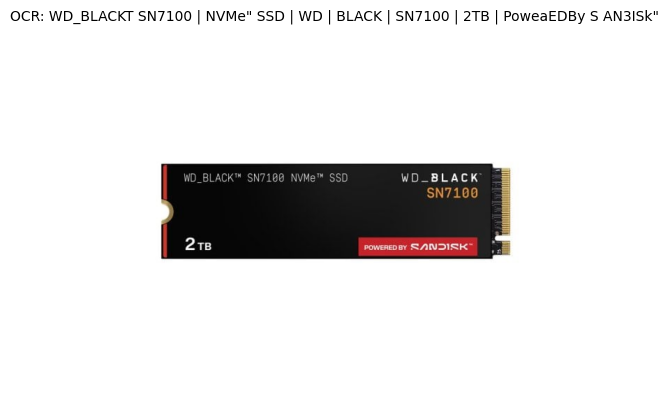

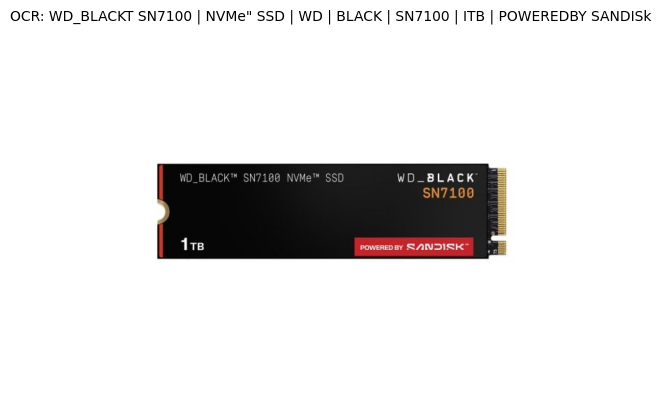

In [57]:
show_component_images(df, label_map, label_num=3, start_idx=0, n_show=3)

#### RAM

En el caso de la memoria RAM, el OCR permite extraer información como la marca y el tipo en la mayoría de los modelos, mostrando resultados consistentes y útiles para el análisis.



--- RAM ---


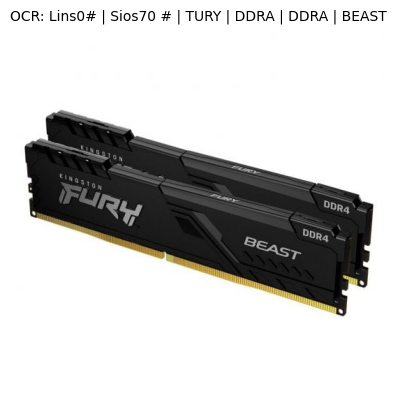

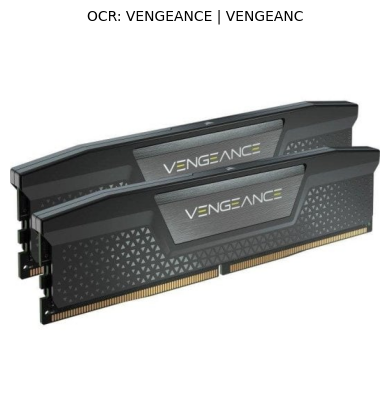

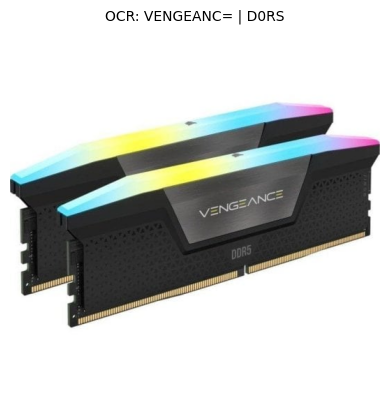

In [58]:
show_component_images(df, label_map, label_num=4, start_idx=0, n_show=3)

#### PC_CASE

Como se observó en las gráficas anteriores, en la mayoría de las cajas de PC el OCR no logra extraer datos, lo cual es totalmente esperado, ya que estos componentes normalmente no presentan texto visible en sus superficies.



--- PC_CASE ---


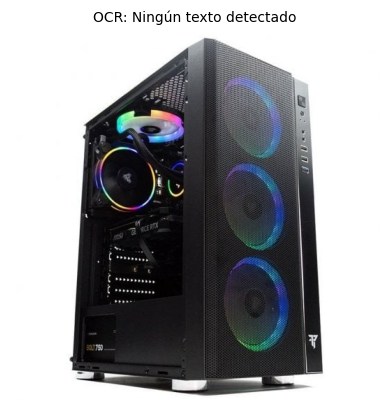

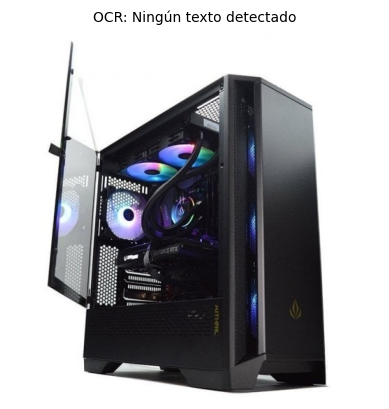

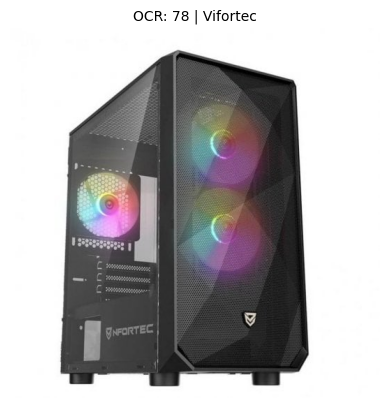

In [59]:
show_component_images(df, label_map, label_num=5, start_idx=0, n_show=3)

#### POWER_SUPPLY

En el caso de las fuentes de alimentación, ocurre lo mismo que con las cajas de PC: el OCR generalmente no logra extraer información, ya que estos componentes rara vez presentan texto visible en la superficie.



--- POWER_SUPPLY ---


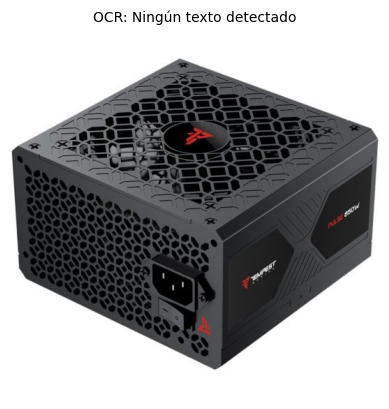

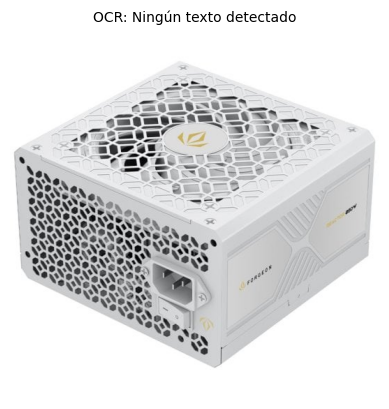

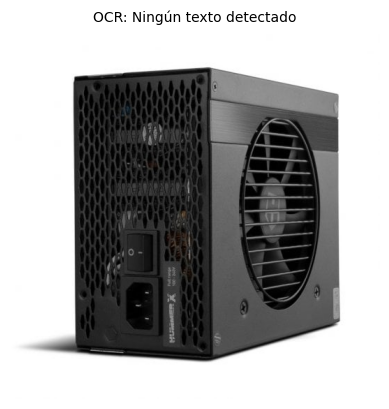

In [61]:
show_component_images(df, label_map, label_num=6, start_idx=0, n_show=3)

#### LIQUID_COOLING

En los sistemas de refrigeración líquida ocurre de manera similar: el OCR generalmente no detecta información, ya que estos componentes no suelen mostrar texto visible en sus superficies.



--- LIQUID_COOLING ---


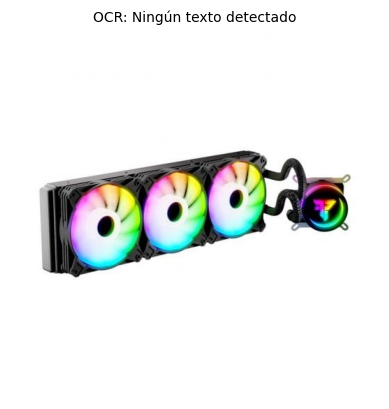

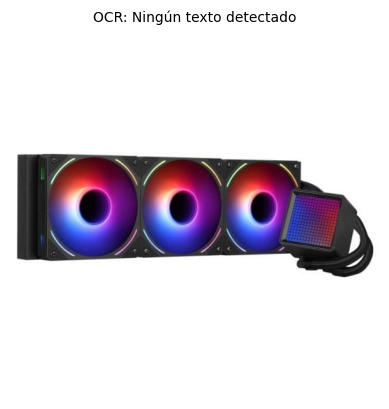

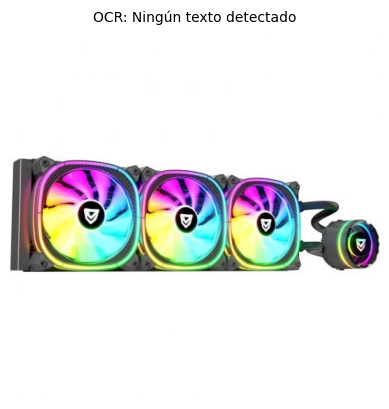

In [62]:
show_component_images(df, label_map, label_num=7, start_idx=0, n_show=3)

#### CASE_FAN

En los ventiladores de caja ocurre lo mismo: el OCR rara vez extrae información, ya que estos componentes normalmente no presentan texto visible en sus superficies.



--- CASE_FAN ---


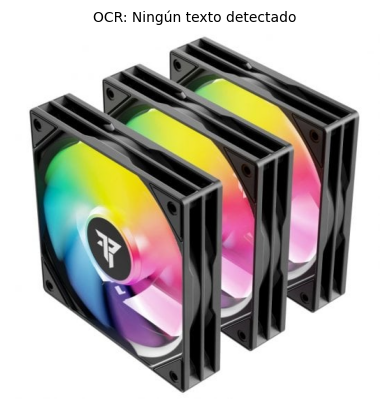

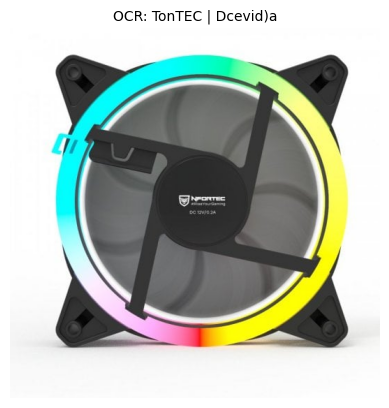

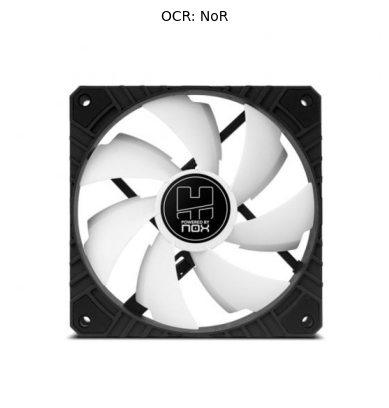

In [63]:
show_component_images(df, label_map, label_num=8, start_idx=0, n_show=3)

#### CPU_FAN

En los ventiladores de CPU sucede de manera similar: el OCR generalmente no detecta texto, ya que estos componentes rara vez tienen información visible en su superficie.



--- CPU_FAN ---


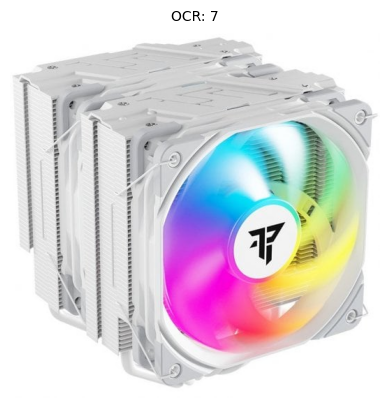

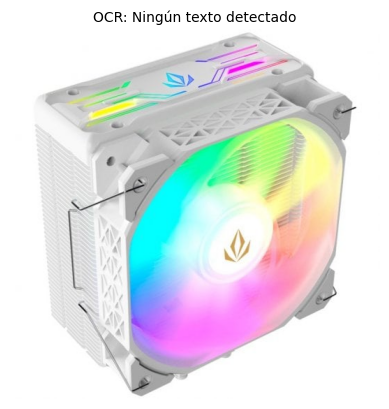

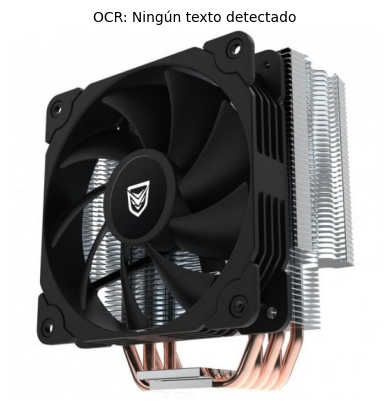

In [64]:
show_component_images(df, label_map, label_num=9, start_idx=0, n_show=3)

#### SOUND_CARD

En el caso de las tarjetas de sonido, el OCR principalmente logra extraer información relacionada con la **marca**, mientras que otros datos suelen ser escasos o inexistentes en la superficie del componente.



--- SOUND_CARD ---


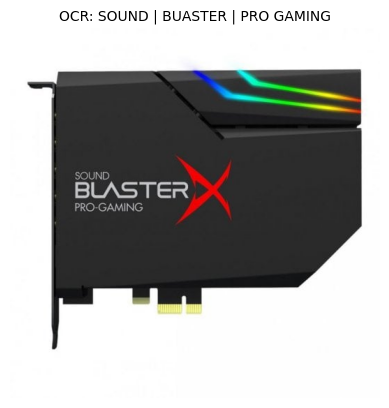

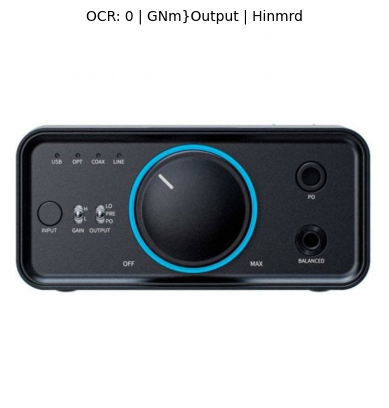

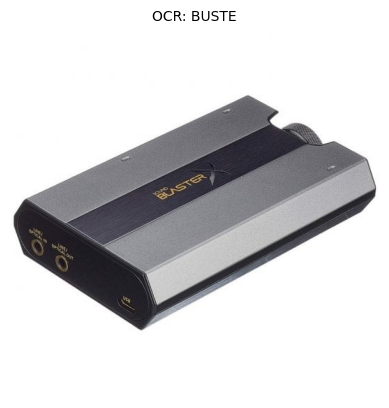

In [65]:
show_component_images(df, label_map, label_num=10, start_idx=0, n_show=3)

### Nube de palabras de los textos OCR

Para entender mejor qué información está capturando nuestro OCR, podemos generar una **nube de palabras** con todos los textos detectados en el dataset.  
Esto nos permitirá visualizar las **marcas, modelos y términos más frecuentes**, y evaluar de manera rápida la utilidad del OCR para nuestro proyecto.


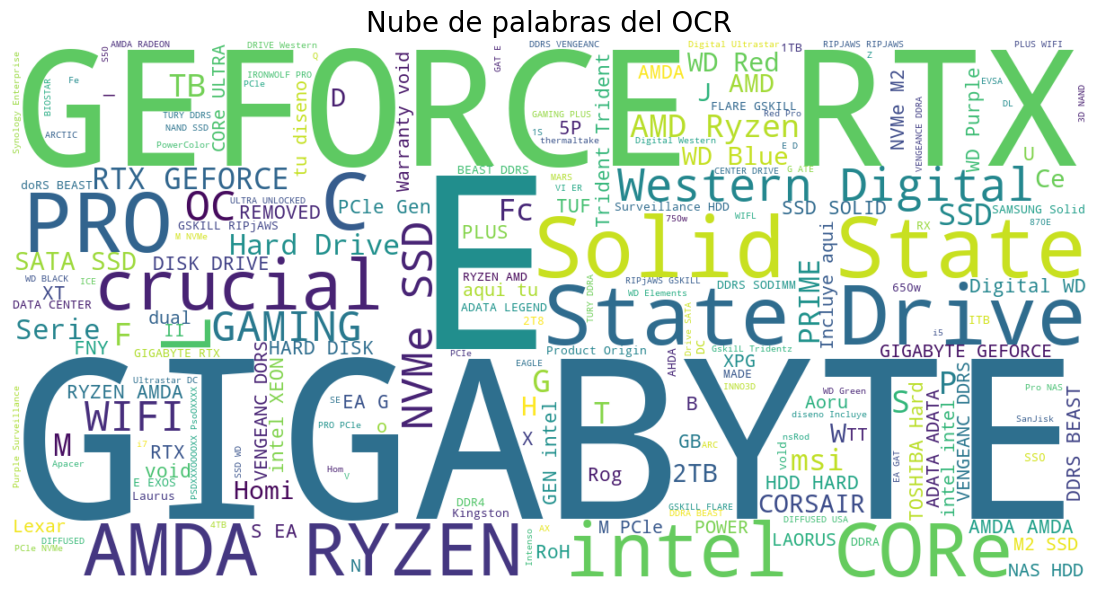

In [68]:
all_texts = " ".join(df['ocr_text'].dropna().astype(str))

wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(all_texts)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras del OCR", fontsize=20)
plt.show()


Podemos observar que, en la nube de palabras, los términos más frecuentes corresponden principalmente a **tipos de componentes y marcas**, lo cual es totalmente coherente. También se pueden identificar **características técnicas**, aunque en menor medida, reflejando la información que el OCR logra extraer de las imágenes.


## Conclusiones

Tras procesar cerca de 10.000 imágenes del dataset con **EasyOCR**, los resultados confirman que esta herramienta será un complemento clave para nuestra red neuronal. Su integración permitirá al agente extraer la mayor cantidad de datos técnicos posibles a partir de las fotos de los usuarios, optimizando así el funcionamiento de la tool.

Aunque, como se había previsto, el sistema presenta dificultades en componentes que apenas tienen texto visible, en aquellos donde hay información y la calidad de la foto es razonable, el modelo es capaz de obtener valores de gran utilidad. Esto permitirá ofrecer al usuario una respuesta mucho más completa y precisa en su modo de uso final.